In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"[REDACTED]","key":"[REDACTED]"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d 'mohammadamireshraghi/blood-cell-cancer-all-4class'

Dataset URL: https://www.kaggle.com/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 1.68G/1.68G [01:16<00:00, 24.1MB/s]
100% 1.68G/1.68G [01:16<00:00, 23.7MB/s]


In [6]:
! kaggle datasets download -d 'mehradaria/leukemia'

Dataset URL: https://www.kaggle.com/datasets/mehradaria/leukemia
License(s): ODbL-1.0
100% 110M/110M [00:06<00:00, 22.3MB/s]
100% 110M/110M [00:06<00:00, 19.2MB/s]


In [7]:
import zipfile

# Extract the downloaded datasets
with zipfile.ZipFile('blood-cell-cancer-all-4class.zip', 'r') as zip_ref:
    zip_ref.extractall('blood-cell-cancer-all-4class')

with zipfile.ZipFile('leukemia.zip', 'r') as zip_ref:
    zip_ref.extractall('leukemia')

# Now you can access the extracted files in the respective folders
# Example: to list files in the blood cell cancer dataset
!ls blood-cell-cancer-all-4class
!ls leukemia

'Blood cell Cancer [ALL]'
Original  Segmented


In [8]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, LearningRateScheduler
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import regularizers
import shutil

In [9]:
# Define source and destination directories
leukemia_dir = 'leukemia/Original'
blood_cancer_dir = 'blood-cell-cancer-all-4class/Blood cell Cancer [ALL]'
merged_dir = 'merged_dataset'

# Create the merged directory if it doesn't exist
if not os.path.exists(merged_dir):
    os.makedirs(merged_dir)

# Function to copy files and rename them based on class
def copy_and_rename(source_dir, dest_dir, class_name, prefix):
    # Ensure the destination class folder exists (creating one if not)
    class_dir = os.path.join(dest_dir, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

    # Copy and rename files
    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check if it's an image file
            source_path = os.path.join(source_dir, filename)
            dest_filename = f"{prefix}_{class_name}_{filename}"
            dest_path = os.path.join(class_dir, dest_filename)
            shutil.copy2(source_path, dest_path)  # Copy the file and preserve metadata

# Combining Early and Malignant_early_Pre-B into one folder
copy_and_rename(os.path.join(leukemia_dir, 'Early'), merged_dir, 'Early_Malignant_early_Pre-B', 'Leukemia')
copy_and_rename(os.path.join(blood_cancer_dir, '[Malignant] early Pre-B'), merged_dir, 'Early_Malignant_early_Pre-B', 'BloodCancer')

# Combining Pre and Malignant_Pro-B into one folder
copy_and_rename(os.path.join(leukemia_dir, 'Pre'), merged_dir, 'Pre_Malignant_Pro-B', 'Leukemia')
copy_and_rename(os.path.join(blood_cancer_dir, '[Malignant] Pro-B'), merged_dir, 'Pre_Malignant_Pro-B', 'BloodCancer')

# Combining Pro and Malignant_Pro-B into one folder
copy_and_rename(os.path.join(leukemia_dir, 'Pro'), merged_dir, 'Pro_Malignant_Pro-B', 'Leukemia')
copy_and_rename(os.path.join(blood_cancer_dir, '[Malignant] Pro-B'), merged_dir, 'Pro_Malignant_Pro-B', 'BloodCancer')

# Combine Benign from both datasets into one folder
copy_and_rename(os.path.join(leukemia_dir, 'Benign'), merged_dir, 'Benign', 'Leukemia')
copy_and_rename(os.path.join(blood_cancer_dir, 'Benign'), merged_dir, 'Benign', 'BloodCancer')

# Print merged dataset location
print(f"Merged dataset created at: {merged_dir}")

# Create a dataframe with image paths and labels
import pandas as pd

image_paths = []
labels = []
for class_name in os.listdir(merged_dir):
    class_dir = os.path.join(merged_dir, class_name)
    if os.path.isdir(class_dir):  # Only process subdirectories (labels)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(class_name)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
print(df.head())
print(df.label.value_counts())

Merged dataset created at: merged_dataset
                                          image_path   label
0  merged_dataset/Benign/BloodCancer_Benign_Snap_...  Benign
1  merged_dataset/Benign/Leukemia_Benign_WBC-Beni...  Benign
2  merged_dataset/Benign/Leukemia_Benign_WBC-Beni...  Benign
3  merged_dataset/Benign/BloodCancer_Benign_Snap_...  Benign
4  merged_dataset/Benign/Leukemia_Benign_WBC-Beni...  Benign
label
Early_Malignant_early_Pre-B    1964
Pre_Malignant_Pro-B            1759
Pro_Malignant_Pro-B            1600
Benign                         1016
Name: count, dtype: int64


In [10]:
class ALLDetectionPipeline:
    def __init__(self, data_dir, image_size=(224, 224), batch_size=16):
        self.data_dir = data_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.train_generator = None
        self.validation_generator = None
        self.model = None
        self.history = None

    def prepare_data(self, validation_split=0.2):
        """Prepare training and validation data with augmentation."""
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=(0.8, 1.2),
            channel_shift_range=30,
            fill_mode='nearest',
            validation_split=validation_split
        )

        val_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

        self.train_generator = train_datagen.flow_from_directory(
            self.data_dir, target_size=self.image_size, batch_size=self.batch_size,
            class_mode='categorical', subset='training', shuffle=True, seed=42
        )
        self.validation_generator = val_datagen.flow_from_directory(
            self.data_dir, target_size=self.image_size, batch_size=self.batch_size,
            class_mode='categorical', subset='validation', shuffle=False, seed=42
        )
        self.class_indices = {v: k for k, v in self.train_generator.class_indices.items()}

    def build_model(self, dropout_rate=0.3):
        """Build classification model using MobileNet with fine-tuning."""
        input_tensor = Input(shape=(*self.image_size, 3))

        # Load pre-trained MobileNet
        base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)
        base_model.trainable = True  # Unfreeze layers for fine-tuning

        for layer in base_model.layers[:-10]:  # Unfreeze selected layers
            layer.trainable = False

        # Add classification head
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        output = Dense(self.train_generator.num_classes, activation='softmax')(x)

        # Build and compile the model
        self.model = Model(inputs=input_tensor, outputs=output)
        self.model.compile(
            optimizer=Adam(learning_rate=1e-4),  # Fine-tuning learning rate
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def train_model(self, epochs=20):
        """Train the classification model."""
        class_weights = {i: len(self.train_generator.classes) /
                         (self.train_generator.num_classes * np.sum(self.train_generator.classes == i))
                         for i in range(self.train_generator.num_classes)}

        callbacks = [
            ModelCheckpoint('model_leukovision.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-5),
            CSVLogger('training_log.csv'),
            LearningRateScheduler(lambda epoch, lr: lr * 0.9 if epoch > 5 else lr)
        ]

        print("Starting model training...")
        try:
            self.history = self.model.fit(
                self.train_generator,
                validation_data=self.validation_generator,
                epochs=epochs,
                callbacks=callbacks,
                class_weight=class_weights,
                verbose=2
            )
            print("Training logs:", self.history.history)
        except Exception as e:
            print("Error during training:", e)

    def evaluate_model(self):
        """Evaluate the model and generate metrics."""
        y_true = self.validation_generator.classes
        y_pred = self.model.predict(self.validation_generator)

        # Classification Report
        print(classification_report(y_true, y_pred.argmax(axis=1)))

        # ROC-AUC Score
        try:
            roc_auc = roc_auc_score(y_true, y_pred, multi_class="ovr")
            print(f"ROC-AUC Score: {roc_auc}")
        except ValueError as e:
            print(f"ROC-AUC could not be computed: {e}")

    def visualize_training(self):
        """Visualize training and validation accuracy/loss."""
        if not self.history:
            print("No training history found.")
            return

        # Plot accuracy
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def predict_image(self, img_path):
        """Predict a single image and display results."""
        img = load_img(img_path, target_size=self.image_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = self.model.predict(img_array)
        predicted_class_index = np.argmax(predictions)
        predicted_class = self.class_indices[predicted_class_index]
        confidence = predictions[0][predicted_class_index]

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
        plt.show()

        return predicted_class, confidence

In [11]:
# Instansiasi pipeline
data_dir = '/content/merged_dataset'
pipeline = ALLDetectionPipeline(data_dir)

In [12]:
pipeline.prepare_data()

Found 5073 images belonging to 4 classes.
Found 1266 images belonging to 4 classes.


In [13]:
pipeline.build_model()

<ipython-input-10-810208a0d377>:45: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
pipeline.train_model(epochs=20)

Starting model training...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


318/318 - 123s - 387ms/step - accuracy: 0.7538 - loss: 1.0457 - val_accuracy: 0.7070 - val_loss: 1.8701 - learning_rate: 1.0000e-04
Epoch 2/20
318/318 - 104s - 327ms/step - accuracy: 0.8224 - loss: 0.8314 - val_accuracy: 0.5308 - val_loss: 1.6799 - learning_rate: 1.0000e-04
Epoch 3/20
318/318 - 103s - 325ms/step - accuracy: 0.8488 - loss: 0.7522 - val_accuracy: 0.6856 - val_loss: 1.2132 - learning_rate: 1.0000e-04
Epoch 4/20
318/318 - 106s - 334ms/step - accuracy: 0.8500 - loss: 0.7351 - val_accuracy: 0.6983 - val_loss: 1.4196 - learning_rate: 1.0000e-04
Epoch 5/20
318/318 - 103s - 324ms/step - accuracy: 0.8585 - loss: 0.6988 - val_accuracy: 0.6738 - val_loss: 1.5567 - learning_rate: 1.0000e-04
Epoch 6/20
318/318 - 143s - 449ms/step - accuracy: 0.8681 - loss: 0.6729 - val_accuracy: 0.7117 - val_loss: 1.8974 - learning_rate: 7.0000e-05
Epoch 7/20
318/318 - 104s - 326ms/step - accuracy: 0.8736 - loss: 0.6526 - val_accuracy: 0.7077 - val_loss: 1.2519 - learning_rate: 6.3000e-05
Epoch 8/20

In [15]:
pipeline.evaluate_model()

80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       203
           1       1.00      0.96      0.98       392
           2       0.54      0.19      0.29       351
           3       0.48      0.82      0.61       320

    accuracy                           0.72      1266
   macro avg       0.74      0.75      0.71      1266
weighted avg       0.73      0.72      0.69      1266

ROC-AUC Score: 0.9113571100392069


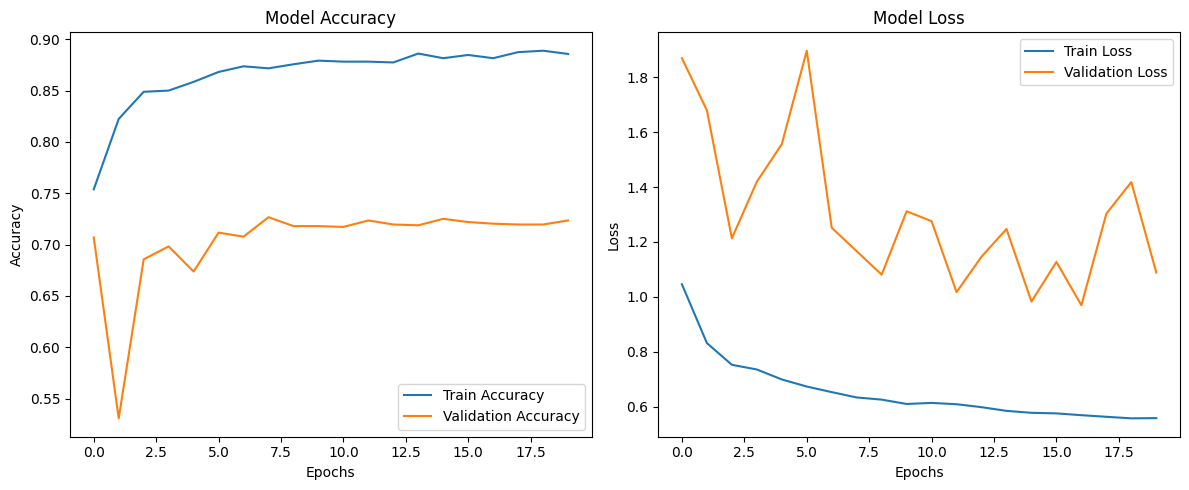

In [16]:
pipeline.visualize_training()

In [17]:
model_save_path = '/content/drive/MyDrive/Colab Notebooks/model_leukovision.keras'
model_save_path = '/content/model_leukovision.keras'

In [19]:
pipeline.model.save('/content/model_leukovision.keras')

In [20]:
import tensorflow as tf

# Misalnya, Anda telah memiliki model yang disimpan sebagai .keras
model_path = 'model_leukovision.keras'
tflite_model_path = 'model_leukovision.tflite'

# Muat model
model = tf.keras.models.load_model(model_path)

# Konversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp957v5_5d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138800021711408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138800011728096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138800011730208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138800011723520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138800011725808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138800011734608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138800011734784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138800011735312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138800011735840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138800011738480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138800011736016

In [21]:
import tensorflow as tf

# Tentukan path ke file model .tflite
tflite_model_path = 'model_leukovision.tflite'

# Muat model .tflite menggunakan Interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

# Alokasikan memori untuk model
interpreter.allocate_tensors()

# Menampilkan info tentang tensor yang ada di dalam model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details:", input_details)
print("Output Details:", output_details)

# Jika tidak ada error, model telah berhasil diimpor
print("Model TensorFlow Lite berhasil dimuat!")

Input Details: [{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 95, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Model TensorFlow Lite berhasil dimuat!


In [22]:
from google.colab import files

# Tentukan path file model .keras
model_path = '/content/model_leukovision.keras'

# Mendownload file model ke komputer lokal Anda
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
from google.colab import files

# Tentukan path model TensorFlow Lite
tflite_model_path = '/content/model_leukovision.tflite'

# Mengunduh model ke komputer lokal Anda
files.download(tflite_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>